In [2]:
# Load the regular expression library
import re
import sys
!{sys.executable} -m pip install inline
!{sys.executable} -m pip install matplotlib
import inline
import matplotlib
import pandas as pd

data = pd.read_csv('april_30_tweets.csv', low_memory=False)

# Filter to only English entries.
data = data[data['lang'] == 'en']

#remove columns other than the tweet, place, or user_location
data.drop(data.columns.difference(['text', 'place', 'user_location']), 1, inplace=True)

#filter out rows that
data1 = data[data.select_dtypes(include='object').apply(lambda x: x.str.contains('california', flags=re.IGNORECASE, regex=True)).all(axis=1)]
data2 = data[data.select_dtypes(include='object').apply(lambda x: x.str.contains('CA')).all(axis=1)]
data = [data1, data2]
result = pd.concat(data)
result.head()
#print(result)

,place,text,user_location
173,NaN,😡 D.A. warns public of 7 ‘high-risk’ sex offen...,NaN
1375,NaN,@BillFOXLA @FOXLA In California Inmates go fre...,"California, USA"
4688,NaN,California is just rockin’ it!! https://t.co/N...,"California, USA"
6094,NaN,7 ‘high-risk’ sex offenders are released out o...,NaN
6606,NaN,Why is Newsom doing this? Why is he not keepi...,NaN


In [3]:
import os
os.chdir('..')

# Remove punctuation
result['tweet_text_processed'] = result['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
result['tweet_text_processed'] = result['tweet_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
result['tweet_text_processed'].head()


173     😡 da warns public of 7 ‘high-risk’ sex offende...
1375    @billfoxla @foxla in california inmates go fre...
4688    california is just rockin’ it https://tco/nsqs...
6094    7 ‘high-risk’ sex offenders are released out o...
6606    why is newsom doing this  why is he not keepin...
Name: tweet_text_processed, dtype: object

In [5]:
!{sys.executable} -m pip install wordcloud

  Using cached wordcloud-1.8.0-cp38-cp38-macosx_10_6_x86_64.whl (162 kB)


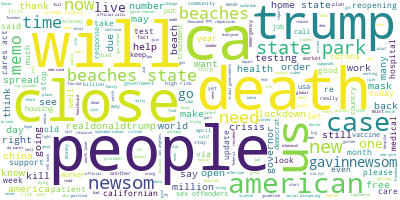

In [4]:
# Import the wordcloud library
from wordcloud import WordCloud, STOPWORDS

# Join the different processed titles together.
long_string = ','.join(list(result['tweet_text_processed'].values))

#add stopwords from twitter and take out covid stuff we know the tweets are about covid
stop_words = ["https", "co", "rt", "tco", "covid", "coronaviru", "covid19", "virus", "coronavirus","19","coronaviruspandemic", "don", "amp", "california", "pandemic"] + list(STOPWORDS)

# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

/Users/marcosgonzalez/Desktop/anaconda3/envs/new-r/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/marcosgonzalez/Desktop/anaconda3/envs/new-r/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


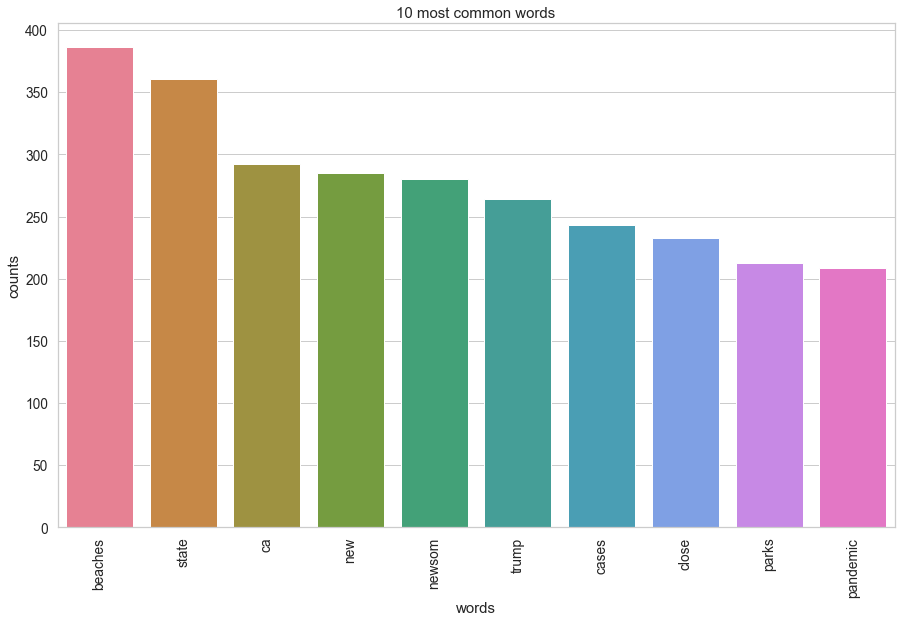

In [8]:
# Load the library with the CountVectorizer method
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install seaborn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import numpy as np

#!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words and same ones from wordcloud
my_additional_stop_words = ["https", "co", "rt", "tco", "covid", "coronaviru", "covid19", "virus", "california", "people", "coronavirus","19","coronaviruspandemic", "don", "amp", "covidー19"]
count_vectorizer = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words))

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(result["tweet_text_processed"])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [9]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

/Users/marcosgonzalez/Desktop/anaconda3/envs/new-r/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topics found via LDA:

Topic #0:
pandemic state trump just cases mask billion new gavinnewsom act

Topic #1:
beaches state close newsom parks memo ca governor america health

Topic #2:
risk sex high offenders released jail da open care gavinnewsom

Topic #3:
new free kill old trump reopening housing weak calls official

Topic #4:
cases deaths new trump pandemic county news realdonaldtrump ca live


In [10]:
%%time

!{sys.executable} -m pip install pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

CPU times: user 1.61 s, sys: 142 ms, total: 1.75 s
Wall time: 5.6 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.028176  0.077640       1        1  23.702698
4     -0.015007  0.033818       2        1  22.741381
1     -0.129028 -0.043855       3        1  19.587689
3      0.100585  0.064871       4        1  18.199615
2      0.071626 -0.132474       5        1  15.768617, topic_info=          Term        Freq       Total Category  logprob  loglift
3511     close  181.000000  181.000000  Default  30.0000  30.0000
13674    state  282.000000  282.000000  Default  29.0000  29.0000
10851    parks  165.000000  165.000000  Default  28.0000  28.0000
2217   beaches  300.000000  300.000000  Default  27.0000  27.0000
10076   newsom  218.000000  218.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
10058      new   18.485056  222.690982   Topic5  -6.1803  -0.6417
14685    trump   18.309186  207.010057   Topic5  -6.1899  -0.5782
6620       gov   16.181878   88.788018   Topic5  -6.3134   0.1448
1605   america   16.179882  122.892574   Topic5  -6.3135  -0.1804
2751        ca   16.342893  228.135947   Topic5  -6.3035  -0.7890

[360 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
63         4  0.818830  0xs4allyt3
137        3  0.775546         12x
208        2  0.947828        1887
226        3  0.070667        1994
226        5  0.918668        1994
...      ...       ...         ...
15828      2  0.217178       world
15828      3  0.205112       world
15828      4  0.337832       world
15828      5  0.084458       world
16271      4  0.917443      zimmer

[685 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 4, 3])